In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from scipy.stats import zscore

In [3]:
df = pd.read_excel("FAOSTAT_data.xlsx")
print(df.shape)
df.head()

(224647, 15)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2019,2019,ha,29203.0,A,Official figure,NaN
1,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2019,2019,kg/ha,1308.3,A,Official figure,NaN
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,1371,"Almonds, in shell",2019,2019,t,38205.0,A,Official figure,NaN
3,QCL,Crops and livestock products,4,Afghanistan,5312,Area harvested,1371,"Almonds, in shell",2020,2020,ha,22134.0,A,Official figure,NaN
4,QCL,Crops and livestock products,4,Afghanistan,5412,Yield,1371,"Almonds, in shell",2020,2020,kg/ha,1775.9,A,Official figure,NaN


In [4]:
df.isnull().sum()

Domain Code              0
Domain                   0
Area Code (M49)          0
Area                     0
Element Code             0
Element                  0
Item Code (CPC)          5
Item                     0
Year Code                0
Year                     0
Unit                     2
Value                 6517
Flag                     4
Flag Description        13
Note                219549
dtype: int64

In [5]:
# Since the null values for Value column account for less than 5% of the total data, we can drop them
# Drop rows where 'Value' is missing 
df = df.dropna(subset=['Value'])

# Drop unnecessary columns (metadata)
df.drop(columns=['Domain Code', 'Domain', 'Area Code (M49)', 'Element Code', 
                 'Item Code (CPC)', 'Year Code', 'Flag', 'Flag Description', 'Note'], inplace=True)

# Drop remaining very minor NaNs if needed
df.dropna(inplace=True)


In [6]:
print(df.shape)
print(df.head())

(218128, 6)
          Area         Element               Item  Year   Unit    Value
0  Afghanistan  Area harvested  Almonds, in shell  2019     ha  29203.0
1  Afghanistan           Yield  Almonds, in shell  2019  kg/ha   1308.3
2  Afghanistan      Production  Almonds, in shell  2019      t  38205.0
3  Afghanistan  Area harvested  Almonds, in shell  2020     ha  22134.0
4  Afghanistan           Yield  Almonds, in shell  2020  kg/ha   1775.9


In [7]:
#Filter only crop-related elements from elements table 
crop_elements = ['Area harvested', 'Yield', 'Production']
df_crop = df[df['Element'].isin(crop_elements)].copy()

#Pivot to reshape
df_pivot = df_crop.pivot_table(
    index=['Area', 'Item', 'Year'],
    columns='Element',
    values='Value'
).reset_index()
df_pivot.head

<bound method NDFrame.head of Element         Area                    Item  Year  Area harvested  \
0        Afghanistan       Almonds, in shell  2019         29203.0   
1        Afghanistan       Almonds, in shell  2020         22134.0   
2        Afghanistan       Almonds, in shell  2021         36862.0   
3        Afghanistan       Almonds, in shell  2022         36462.0   
4        Afghanistan       Almonds, in shell  2023         37000.0   
...              ...                     ...   ...             ...   
82121       Zimbabwe   Whole milk, condensed  2022             NaN   
82122       Zimbabwe  Whole milk, evaporated  2019             NaN   
82123       Zimbabwe  Whole milk, evaporated  2020             NaN   
82124       Zimbabwe  Whole milk, evaporated  2021             NaN   
82125       Zimbabwe  Whole milk, evaporated  2022             NaN   

Element  Production   Yield  
0          38205.00  1308.3  
1          39307.00  1775.9  
2          64256.00  1743.2  
3        

In [8]:
# Rename columns according to units in the Unit column
df_pivot.columns.name = None
df_pivot.rename(columns={
    'Area harvested': 'Area_Harvested_ha',
    'Yield': 'Yield_kg_ha',
    'Production': 'Production_ton'
}, inplace=True)


print(df_pivot.head())
df_pivot.to_csv("clean_crop_dataset.csv", index=False)


          Area               Item  Year  Area_Harvested_ha  Production_ton  \
0  Afghanistan  Almonds, in shell  2019            29203.0         38205.0   
1  Afghanistan  Almonds, in shell  2020            22134.0         39307.0   
2  Afghanistan  Almonds, in shell  2021            36862.0         64256.0   
3  Afghanistan  Almonds, in shell  2022            36462.0         63515.0   
4  Afghanistan  Almonds, in shell  2023            37000.0         67000.0   

   Yield_kg_ha  
0       1308.3  
1       1775.9  
2       1743.2  
3       1742.0  
4       1810.8  


In [9]:
#EDA
print(df_pivot.shape)
print(df_pivot.describe())

(82126, 6)
               Year  Area_Harvested_ha  Production_ton    Yield_kg_ha
count  82126.000000       4.790100e+04    8.194400e+04   50572.000000
mean    2020.928281       1.712810e+05    9.179694e+05   12705.650799
std        1.383827       1.429958e+06    1.054049e+07   26319.565219
min     2019.000000       0.000000e+00    0.000000e+00       0.000000
25%     2020.000000       2.900000e+02    8.094600e+02    1491.525000
50%     2021.000000       3.005000e+03    1.071800e+04    5461.300000
75%     2022.000000       2.326000e+04    9.881106e+04   14812.500000
max     2023.000000       4.783200e+07    7.825858e+08  705196.700000


In [10]:
print(df_pivot.isnull().sum())

Area                     0
Item                     0
Year                     0
Area_Harvested_ha    34225
Production_ton         182
Yield_kg_ha          31554
dtype: int64


In [13]:
#Imputing missing values with mean
df_pivot['Area_Harvested_ha'].fillna(df_pivot['Area_Harvested_ha'].mean(), inplace=True)
df_pivot['Yield_kg_ha'].fillna(df_pivot['Yield_kg_ha'].mean(), inplace=True)
df_pivot['Production_ton'].fillna(df_pivot['Production_ton'].mean(), inplace=True)
print(df_pivot.isnull().sum())
# Save the cleaned dataset
df_pivot.to_csv("clean_crop_dataset.csv", index=False)

C:\Users\Chia\AppData\Local\Temp\ipykernel_14360\314654473.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pivot['Area_Harvested_ha'].fillna(df_pivot['Area_Harvested_ha'].mean(), inplace=True)
C:\Users\Chia\AppData\Local\Temp\ipykernel_14360\314654473.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

Area                 0
Item                 0
Year                 0
Area_Harvested_ha    0
Production_ton       0
Yield_kg_ha          0
dtype: int64


In [18]:
print(df_pivot['Item'].unique())

['Almonds, in shell'
 'Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw'
 'Apples' 'Apricots' 'Barley' 'Butter and ghee of sheep milk'
 'Butter of cow milk' 'Buttermilk, dry' 'Cantaloupes and other melons'
 'Cattle fat, unrendered' 'Cheese from milk of goats, fresh or processed'
 'Cheese from milk of sheep, fresh or processed' 'Cotton lint, ginned'
 'Cotton seed' 'Cottonseed oil'
 'Edible offal of cattle, fresh, chilled or frozen'
 'Edible offal of goat, fresh, chilled or frozen'
 'Edible offal of sheep, fresh, chilled or frozen'
 'Edible offals of camels and other camelids, fresh, chilled or frozen'
 'Fat of camels' 'Figs' 'Game meat, fresh, chilled or frozen'
 'Goat fat, unrendered' 'Grapes' 'Hen eggs in shell, fresh' 'Linseed'
 'Maize (corn)' 'Meat of camels, fresh or chilled'
 'Meat of cattle with the bone, fresh or chilled'
 'Meat of chickens, fresh or chilled' 'Meat of goat, fresh or chilled'
 'Meat of sheep, fresh or chilled' 'Millet' 'Molasses' 'Mustard

In [19]:
crop_keywords=crops = [
    "Almonds",
    "Anise, coriander, cumin, caraway, fennel, juniper berries",
    "Apples",
    "Apricots",
    "Barley",
    "Cantaloupes (and other melons)",
    "Cotton (lint, seed, seed oil)",
    "Figs",
    "Grapes",
    "Linseed",
    "Maize (corn)",
    "Millet",
    "Mustard seed",
    "Olives",
    "Onions and shallots (dry and green)",
    "Oranges",
    "Berries (various, incl. vaccinium genus)",
    "Citrus fruits (other)",
    "Fruits (other)",
    "Nuts (various, incl. pistachios, cashew, Brazil, etc.)",
    "Pulses (various incl. lentils, peas, chickpeas, beans)",
    "Stone fruits (peaches, plums, cherries, etc.)",
    "Vegetables (various: cabbage, carrots, tomatoes, cucumbers, etc.)",
    "Pears",
    "Potatoes",
    "Rice",
    "Sesame seed",
    "Soya beans",
    "Sugar cane",
    "Sunflower seed",
    "Walnuts",
    "Watermelons",
    "Wheat",
    "Beans (dry and green)",
    "Cabbages",
    "Carrots and turnips",
    "Cauliflowers and broccoli",
    "Cherries",
    "Chestnuts",
    "Chillies and peppers (dry and green)",
    "Cucumbers and gherkins",
    "Dates",
    "Eggplants (aubergines)",
    "Garlic (green)",
    "Green tea",
    "Leeks and other alliaceous vegetables",
    "Lemons and limes",
    "Lettuce and chicory",
    "Mushrooms and truffles",
    "Oats",
    "Okra",
    "Peas",
    "Pumpkins, squash, gourds",
    "Quinces",
    "Rye",
    "Sorghum",
    "Strawberries",
    "Tangerines, mandarins, clementines",
    "Tomatoes",
    "Artichokes",
    "Bananas",
    "Groundnuts (peanuts)",
    "Locust beans (carobs)",
    "Tropical fruits (papayas, mangoes, guavas, etc.)",
    "Pomelos and grapefruits",
    "Rape or colza seed",
    "Triticale",
    "Avocados",
    "Cassava",
    "Castor oil seeds",
    "Cocoa beans",
    "Coffee (green)",
    "Kenaf and other textile bast fibres",
    "Palm kernels",
    "Pineapples",
    "Sisal",
    "Sweet potatoes",
    "Taro",
    "Yams",
    "Asparagus",
    "Canary seed",
    "Cereals (n.e.c.)",
    "Lupins",
    "Maté leaves",
    "Fibre crops (other)",
    "Oil seeds (other)",
    "Peppermint, spearmint",
    "Safflower seed",
    "String beans",
    "Tea leaves",
    "Tung nuts",
    "Hazelnuts",
    "Blueberries",
    "Cow peas",
    "Currants",
    "Ginger (raw)",
    "Hempseed",
    "Kiwi fruit",
    "Persimmons",
    "Raspberries",
    "Mixed grain",
    "Cranberries",
    "Coconuts",
    "Pigeon peas",
    "Plantains and cooking bananas",
    "Areca nuts",
    "Sugar crops (other)",
    "Buckwheat",
    "Pome fruits (other)",
    "Edible roots and tubers (high starch/inulin)",
    "Yautia",
    "Fonio",
    "Karite nuts (sheanuts)",
    "Kola nuts",
    "Melonseed",
    "Pepper (Piper spp.)",
    "Nutmeg, mace, cardamoms",
    "Quinoa",
    "Brazil nuts",
    "Pyrethrum (dried flowers)",
    "Chicory roots",
    "Cashewapple",
    "Cassava leaves",
    "Bambara beans",
    "Cinnamon",
    "Cloves",
    "Agave fibres",
    "Poppy seed",
    "Kapok fibre, fruit, and seed",
    "Gooseberries",
    "Jojoba seeds"
]
# Filter the DataFrame to include only rows where 'Item' contains any of the crop keywords
df_filtered = df_pivot[df_pivot['Item'].str.contains('|'.join(crop_keywords), case=False, na=False)]
# Save the filtered DataFrame to a new CSV file
df_filtered.to_csv("filtered_crop_dataset.csv", index=False)
print(df_filtered.shape)

C:\Users\Chia\AppData\Local\Temp\ipykernel_14360\1990997119.py:135: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtered = df_pivot[df_pivot['Item'].str.contains('|'.join(crop_keywords), case=False, na=False)]


(32994, 6)


In [20]:
df_filtered.sample(5)

,Area,Item,Year,Area_Harvested_ha,Production_ton,Yield_kg_ha
42480,Latvia,Wheat,2021,537300.00000,2407700.00,4481.100000
39829,Kazakhstan,Mushrooms and truffles,2022,171281.03645,513.56,12705.650799
12501,Canada,Cucumbers and gherkins,2021,2420.00000,57720.00,23851.200000
51688,Nepal,Pears,2020,2306.00000,22867.00,9916.300000
46947,Malta,"Cheese from milk of goats, fresh or processed",2022,171281.03645,0.00,12705.650799


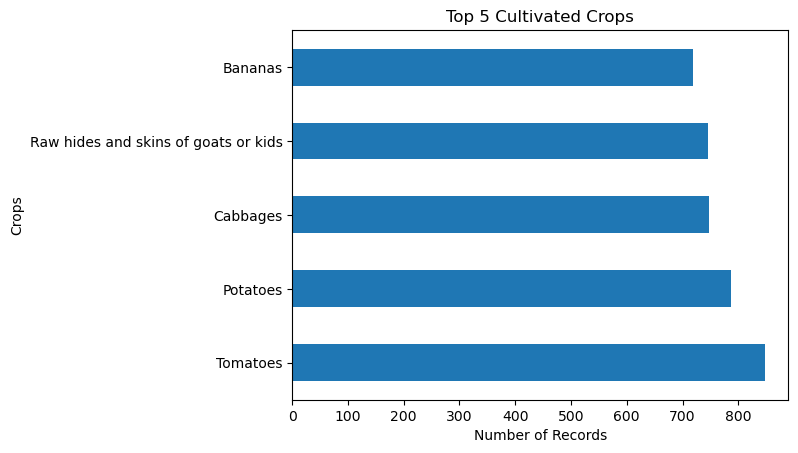

In [21]:
# Most frequently reported crops
df_filtered['Item'].value_counts().head(5).plot(kind='barh', title='Top 5 Cultivated Crops')
plt.xlabel('Number of Records')
plt.ylabel('Crops')
plt.show()

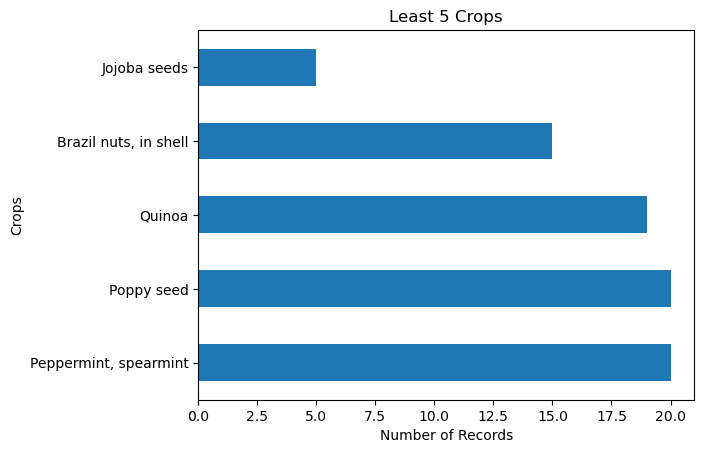

In [ ]:
#least frequently reported crops
df_filtered['Item'].value_counts().tail(5).plot(kind='barh', title='Least 5 Crops')
plt.xlabel('Number of Records')
plt.ylabel('Crops')
plt.show()

<Axes: title={'center': 'Top 5 Countries/Regions'}, ylabel='Area'>

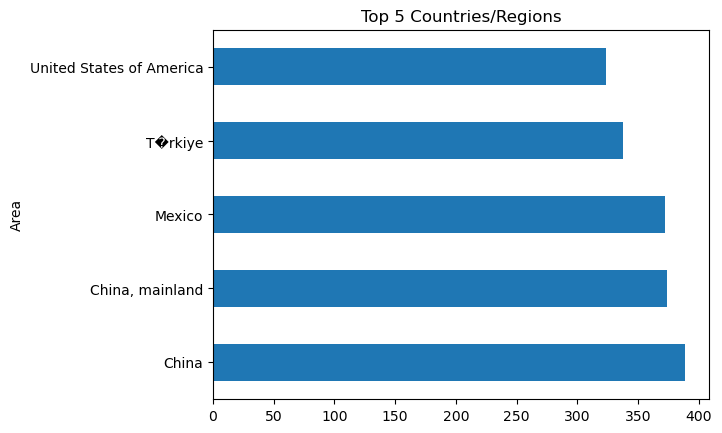

In [22]:
# Most active regions
df_filtered['Area'].value_counts().head(5).plot(kind='barh', title='Top 5 Countries/Regions')

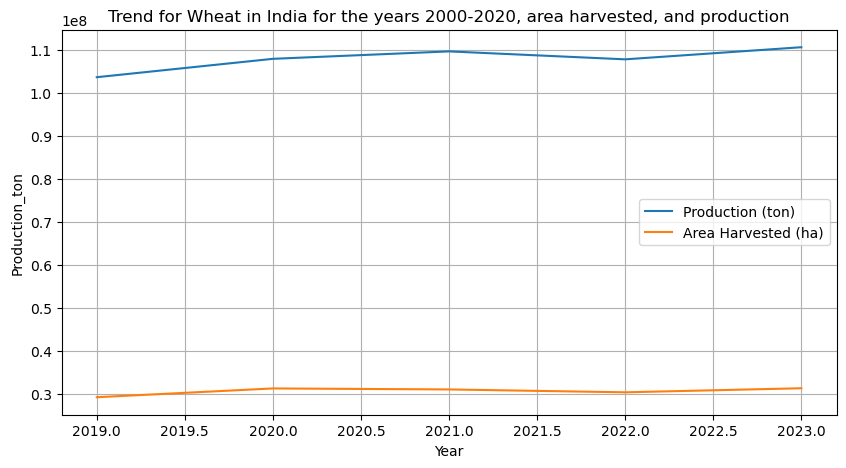

In [ ]:
#trend for a specific crop based on area. Production and area harvested for years 2000-2020
crop = 'Wheat'
area = 'India'
df_crop_area = df_filtered[(df_filtered['Item'] == crop) & (df_filtered['Area'] == area)]

plt.figure(figsize=(10,5))
sns.lineplot(data=df_crop_area, x='Year', y='Production_ton', label='Production (ton)')
sns.lineplot(data=df_crop_area, x='Year', y='Area_Harvested_ha', label='Area Harvested (ha)')
plt.title(f'Trend for {crop} in {area} for the years 2000-2020, area harvested, and production')
plt.legend()
plt.grid()
plt.show()


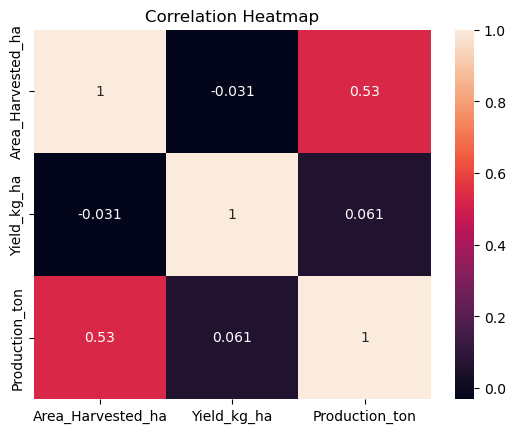

In [ ]:
sns.heatmap(df_filtered[['Area_Harvested_ha', 'Yield_kg_ha', 'Production_ton']].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

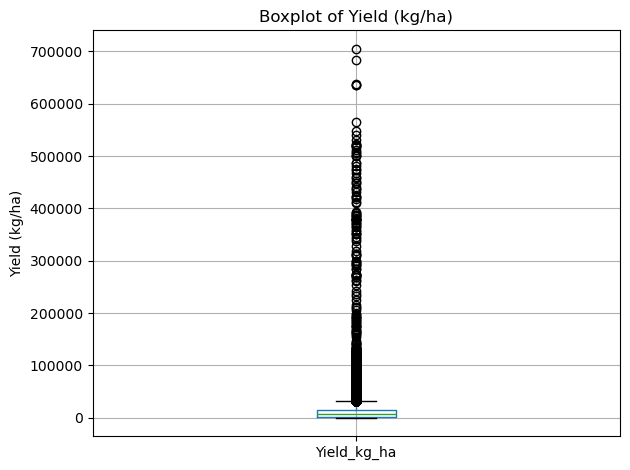

In [ ]:
#Boxplot to look for outliers
df_filtered.boxplot(column='Yield_kg_ha')
plt.title("Boxplot of Yield (kg/ha)")
plt.ylabel("Yield (kg/ha)")

plt.tight_layout()
plt.show()

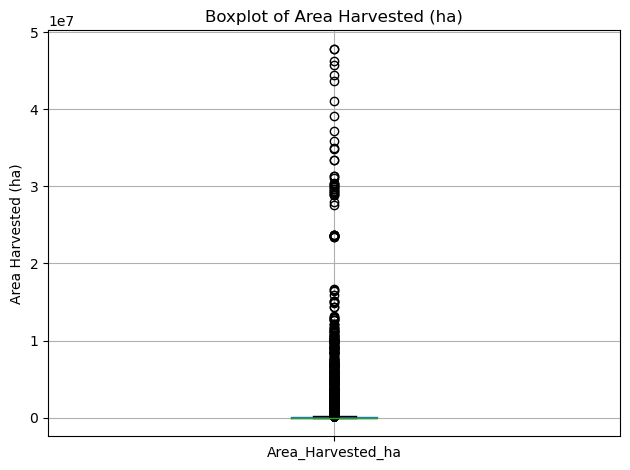

In [ ]:
#Boxplot to look for outliers
df_filtered.boxplot(column='Area_Harvested_ha')
plt.title("Boxplot of Area Harvested (ha)")
plt.ylabel("Area Harvested (ha)")

plt.tight_layout()
plt.show()

In [23]:
df_cleaned = df_filtered.copy()
# Select numerical columns to apply Z-score on
numeric_cols = ['Yield_kg_ha', 'Production_ton', 'Area_Harvested_ha']
# Calculate Z-scores
z_scores = df_cleaned[numeric_cols].apply(zscore)
# Filter out rows where Z-score is less than threshold (e.g., |z| < 1)
df_cleaned = df_filtered[(z_scores < 0.5).all(axis=1)]
# Check how much data remains
print(f"Original shape: {df_filtered.shape}")
print(f"Cleaned shape: {df_cleaned.shape}")

Original shape: (32994, 6)
Cleaned shape: (28247, 6)


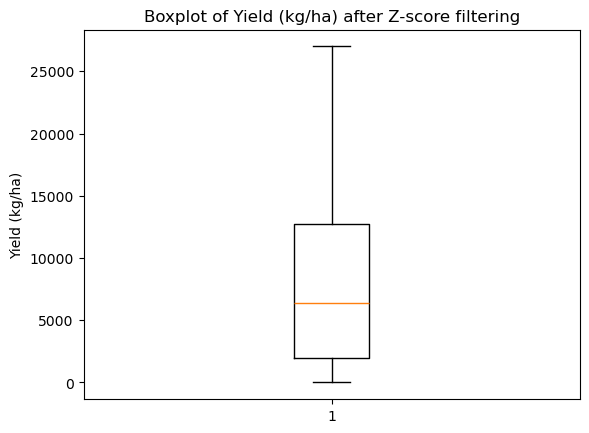

In [ ]:
plt.boxplot(df_cleaned['Yield_kg_ha'])
plt.title("Boxplot of Yield (kg/ha) after Z-score filtering")
plt.ylabel("Yield (kg/ha)")
plt.show()

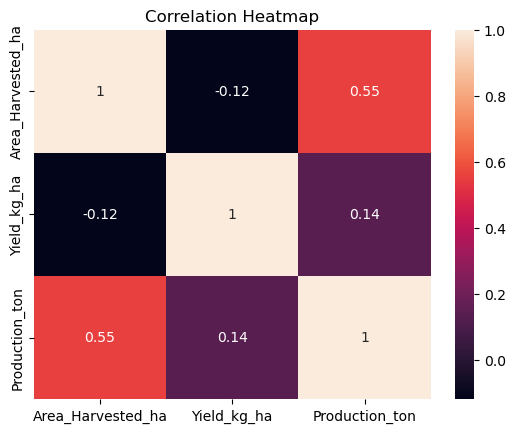

In [ ]:
sns.heatmap(df_cleaned[['Area_Harvested_ha', 'Yield_kg_ha', 'Production_ton']].corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [24]:
# Productivity ratio = production per hectare
df_cleaned['Productivity'] = df_cleaned['Production_ton'] / df_cleaned['Area_Harvested_ha']
df_cleaned[['Productivity']].describe()

C:\Users\Chia\AppData\Local\Temp\ipykernel_14360\1436323811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Productivity'] = df_cleaned['Production_ton'] / df_cleaned['Area_Harvested_ha']


,Productivity
count,2.640700e+04
mean,inf
std,NaN
min,0.000000e+00
25%,1.083333e+00
50%,3.934211e+00
75%,1.049036e+01
max,inf


In [ ]:
features = ['Area_Harvested_ha', 'Yield_kg_ha', 'Year']
target = 'Production_ton'
X = df_cleaned[features]
y = df_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [ ]:
def evaluate_model(y_true, y_pred, name='Model'):
    print(f"🔹 {name} Performance:")
    print("R² Score:", r2_score(y_true, y_pred))
    print("RMSE:", (mean_squared_error(y_true, y_pred))** 0.5)

In [ ]:
evaluate_model(y_test, y_pred_lr, name='Linear Regression')

🔹 Linear Regression Performance:
R² Score: 0.36955045768993866
RMSE: 447088.63042326673


In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_model(y_test, y_pred_rf, name='Random Forest')

🔹 Random Forest Performance:
R² Score: 0.8909519644451708
RMSE: 185941.95040338056


In [ ]:
# Save model
joblib.dump(rf, 'random_forest_model.pkl')
joblib.dump(lr, 'linear_regression_model.pkl')

['linear_regression_model.pkl']